# Process Simulation — Cool Visuals

This notebook contains a compact, visualization-first presentation of the process simulation results. All imports are in the first code cell so you can rerun cells quickly.

In [14]:
# Imports (all gathered here)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import importlib

# import modules (so we can reload them after edits)
import sim_dsl.simpy_adapter as _simpy_adapter
import sim_dsl.visualizers as _visualizers
from sim_dsl.core import ProcessModel, State
from sim_dsl.resources import Resource

# reload to pick up any recent edits to these modules
importlib.reload(_simpy_adapter)
importlib.reload(_visualizers)

# bring helper functions into local namespace (Result API)
from sim_dsl.simpy_adapter import simulate
from sim_dsl.visualizers import (
    plot_state_counts_result,
    plot_state_percent_result,
    plot_resource_occupancy_result,
)

# plotting style
plt.style.use('seaborn-v0_8')

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'State counts over time (waiting vs service)'}, xlabel='Time (hr)', ylabel='Count'>)

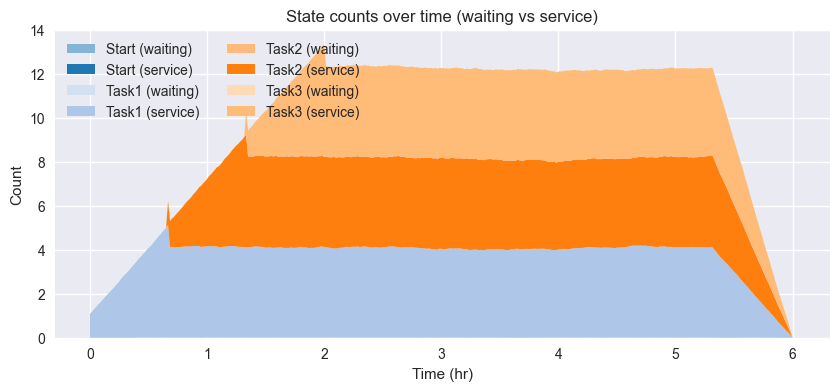

In [ ]:
# Scenario 1: different workers do different tasks
# parameters (minutes)
switching_cost = 10
task1_time = 30
task2_time = 30
task3_time = 30
arrival_rate_per_min = 1/10

s_hr = switching_cost/60.0
t1_hr = task1_time/60.0
t2_hr = task2_time/60.0
t3_hr = task3_time/60.0

p1 = ProcessModel('scenario1_diff_workers')
# build states and transitions explicitly
h1 = Resource('Worker1', cost=50.0, capacity=10)
h2 = Resource('Worker2', cost=50.0, capacity=10)
h3 = Resource('Worker3', cost=50.0, capacity=10)
start = State('Start', time=0.0)

task1 = State('Task1', time=s_hr+t1_hr, resource=h1)
task2 = State('Task2', time=s_hr+t2_hr, resource=h2)
task3 = State('Task3', time=s_hr+t3_hr, resource=h3)
success = State('Success')

p1.add_state(start)
p1.add_state(task1)
p1.add_state(task2)
p1.add_state(task3)
p1.add_state(success)
p1.add_transition(start >> 1.0 >> task1)
p1.add_transition(task1 >> 1.0 >> task2)
p1.add_transition(task2 >> 1.0 >> task3)
p1.add_transition(task3 >> 1.0 >> success)

# run and plot
from sim_dsl.simpy_adapter import SimulationParameters, SimulationSettings
params = SimulationParameters(runs=50)  # run until completion (no arrival rate, no end time)
settings = SimulationSettings(simulations=1000)
res1 = simulate(p1, parameters=params, settings=settings)

plot_state_counts_result(res1, exclude_terminal=True, split_service=True)

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'State counts over time (waiting vs service)'}, xlabel='Time (hr)', ylabel='Count'>)

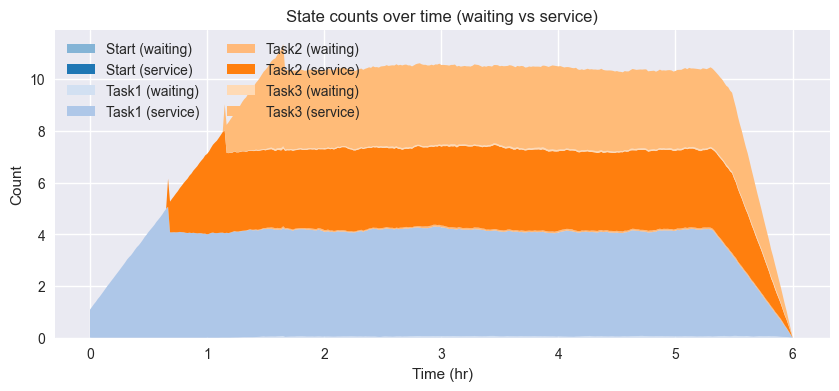

In [ ]:
# Scenario 2: single person does all three tasks
from sim_dsl.core import ProcessModel, State
from sim_dsl.resources import Resource

# parameters (minutes)
switching_cost = 10
task1_time = 30
task2_time = 30
task3_time = 30
arrival_rate_per_min = 1/10.0

s_hr = switching_cost/60.0
t1_hr = task1_time/60.0
t2_hr = task2_time/60.0
t3_hr = task3_time/60.0

p2 = ProcessModel('scenario2_single_worker')
worker = Resource('SoloWorker', cost=50.0, capacity=15)
start = State('Start', time=0.0)
task1 = State('Task1', time=s_hr+t1_hr, resource=worker)
task2 = State('Task2', time=t2_hr, resource=worker)
task3 = State('Task3', time=t3_hr, resource=worker)
success = State('Success')
p2.add_state(start)
p2.add_state(task1)
p2.add_state(task2)
p2.add_state(task3)
p2.add_state(success)
p2.add_transition(start >> 1.0 >> task1)
p2.add_transition(task1 >> 1.0 >> task2)
p2.add_transition(task2 >> 1.0 >> task3)
p2.add_transition(task3 >> 1.0 >> success)

from sim_dsl.simpy_adapter import SimulationParameters, SimulationSettings
params = SimulationParameters(runs=50)  # run until completion
settings = SimulationSettings(simulations=1000)
res2 = simulate(p2, parameters=params, settings=settings)
plot_state_counts_result(res2, exclude_terminal=True, split_service=True)

## Scenario 3: AI does the middle step (with human fallback)

We introduce an AI resource for the middle task. On AI failure, we switch back to a human and incur the switching cost. We then proceed to Task3 with a human.


(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'State counts over time (waiting vs service)'}, xlabel='Time (hr)', ylabel='Count'>)

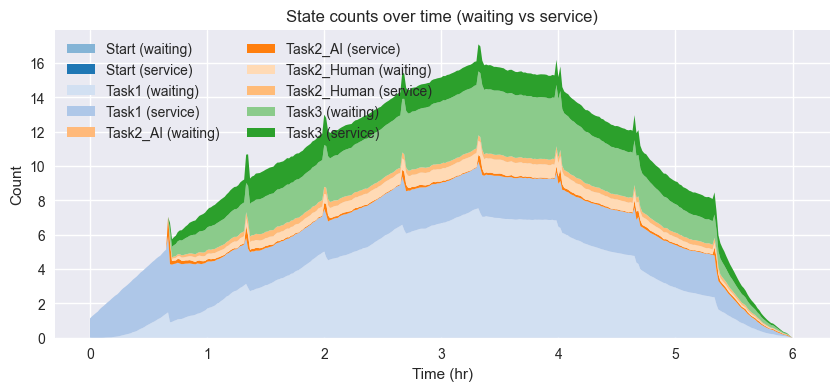

In [ ]:
# Scenario 3: AI does middle step with fallback to human on failure (switching folded into human service)
from sim_dsl.core import ProcessModel, State
from sim_dsl.resources import Resource
from sim_dsl.simpy_adapter import SimulationParameters, SimulationSettings

# parameters (minutes)
switching_cost = 10
agent_processing_min = 1
agent_success_rate = 0.8
arrival_rate_per_min = 1/10.0

# convert to hours
s_hr = switching_cost/60.0
agent_hr = agent_processing_min/60.0

p3 = ProcessModel('scenario3_agent_middle')
worker = Resource('Human', cost=50.0, capacity=20)
ai = Resource('AI', cost=5.0, capacity=20)

start = State('Start', time=0.0)
# switching is included in the next human service states
task1 = State('Task1', time=(0.5 + s_hr), resource=worker)

task2_ai = State('Task2_AI', time=agent_hr, resource=ai)
# if AI fails, switching back to human is included here
task2_human = State('Task2_Human', time=(0.5 + s_hr), resource=worker)

# Task3 follows AI (or human rework); fold switching into Task3 service to avoid post-switch queueing
task3 = State('Task3', time=(0.5 + s_hr), resource=worker)
success = State('Success')

for s in [start, task1, task2_ai, task2_human, task3, success]:
    p3.add_state(s)

# flow: start -> human Task1 -> AI Task2 -> (success -> Task3) | (fail -> Human Task2 -> Task3) -> Success
p3.add_transition(start >> 1.0 >> task1)
p3.add_transition(task1 >> 1.0 >> task2_ai)
# AI outcomes
p3.add_transition(task2_ai >> agent_success_rate >> task3)
p3.add_transition(task2_ai >> (1-agent_success_rate) >> task2_human)
# human fallback then proceeds to Task3
p3.add_transition(task2_human >> 1.0 >> task3)
# finish
p3.add_transition(task3 >> 1.0 >> success)

params = SimulationParameters(runs=50)  # run until completion
settings = SimulationSettings(simulations=400)
res3 = simulate(p3, parameters=params, settings=settings)

plot_state_counts_result(res3, exclude_terminal=True, split_service=True)


## Scenario 4: AI does last two steps, human check at the end

AI attempts Task2 and Task3. A human check at the end incurs switching; on failure, a human reworks Task2+Task3.


(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'State counts over time (waiting vs service)'}, xlabel='Time (hr)', ylabel='Count'>)

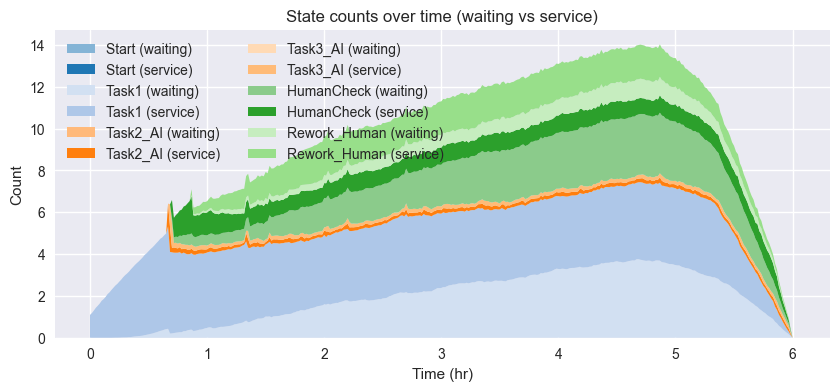

In [ ]:
# Scenario 4: AI does last two steps; human check and potential rework (switching folded into human service)
from sim_dsl.core import ProcessModel, State
from sim_dsl.resources import Resource
from sim_dsl.simpy_adapter import SimulationParameters, SimulationSettings

# parameters (minutes)
switching_cost = 10
agent_processing_min = 1
agent_success_rate = 0.8
arrival_rate_per_min = 1/10.0

s_hr = switching_cost/60.0
agent_hr = agent_processing_min/60.0

p4 = ProcessModel('scenario4_ai_last_two')
human = Resource('Human', cost=50.0, capacity=6)
ai = Resource('AI', cost=5.0, capacity=30)

start = State('Start', time=0.0)
# initial switching folded into Task1
Task1 = State('Task1', time=(0.5 + s_hr), resource=human)

Task2_AI = State('Task2_AI', time=agent_hr, resource=ai)
Task3_AI = State('Task3_AI', time=agent_hr, resource=ai)

# human check includes switching cost; rework includes switching implicitly in its service time
human_check = State('HumanCheck', time=(0.0 + s_hr), resource=human)
rework = State('Rework_Human', time=(0.5 + 0.5 + s_hr), resource=human)
success = State('Success')

for s in [start, Task1, Task2_AI, Task3_AI, human_check, rework, success]:
    p4.add_state(s)

p4.add_transition(start >> 1.0 >> Task1)
p4.add_transition(Task1 >> 1.0 >> Task2_AI)
p4.add_transition(Task2_AI >> 1.0 >> Task3_AI)
p4.add_transition(Task3_AI >> 1.0 >> human_check)

overall_success_prob = agent_success_rate * agent_success_rate
p4.add_transition(human_check >> overall_success_prob >> success)
p4.add_transition(human_check >> (1-overall_success_prob) >> rework)
p4.add_transition(rework >> 1.0 >> success)

params = SimulationParameters(runs=50)  # run until completion
settings = SimulationSettings(simulations=400)
res4 = simulate(p4, parameters=params, settings=settings)

plot_state_counts_result(res4, exclude_terminal=True, split_service=True)


## Scenario 5: AI does all three tasks, human check at the end

AI performs all tasks; a human check may trigger a full human rework of the path.


(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'State counts over time (waiting vs service)'}, xlabel='Time (hr)', ylabel='Count'>)

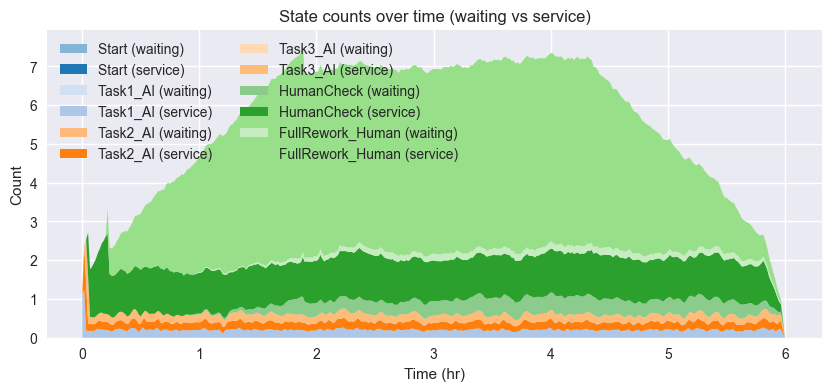

In [ ]:
# Scenario 5: AI does all tasks; human check and potential full rework (switching folded into human service)
from sim_dsl.core import ProcessModel, State
from sim_dsl.resources import Resource
from sim_dsl.simpy_adapter import SimulationParameters, SimulationSettings

# parameters (minutes)
switching_cost = 10
agent_processing_min = 1
agent_success_rate = 0.8
arrival_rate_per_min = 1/10.0

s_hr = switching_cost/60.0
agent_hr = agent_processing_min/60.0

p5 = ProcessModel('scenario5_ai_all')
human = Resource('Human', cost=50.0, capacity=8)
ai = Resource('AI', cost=5.0, capacity=40)

start = State('Start', time=0.0)
Task1_AI = State('Task1_AI', time=agent_hr, resource=ai)
Task2_AI = State('Task2_AI', time=agent_hr, resource=ai)
Task3_AI = State('Task3_AI', time=agent_hr, resource=ai)

# human check includes switching cost
human_check = State('HumanCheck', time=(0.0 + s_hr), resource=human)
# full human rework includes switching folded into its service time
rework = State('FullRework_Human', time=(0.5 + 0.5 + 0.5 + s_hr), resource=human)
success = State('Success')

for s in [start, Task1_AI, Task2_AI, Task3_AI, human_check, rework, success]:
    p5.add_state(s)

p5.add_transition(start >> 1.0 >> Task1_AI)
p5.add_transition(Task1_AI >> 1.0 >> Task2_AI)
p5.add_transition(Task2_AI >> 1.0 >> Task3_AI)
p5.add_transition(Task3_AI >> 1.0 >> human_check)

overall_success_prob = agent_success_rate ** 3
p5.add_transition(human_check >> overall_success_prob >> success)
p5.add_transition(human_check >> (1-overall_success_prob) >> rework)
p5.add_transition(rework >> 1.0 >> success)

params = SimulationParameters(runs=50)  # run until completion
settings = SimulationSettings(simulations=400)
res5 = simulate(p5, parameters=params, settings=settings)

plot_state_counts_result(res5, exclude_terminal=True, split_service=True)


In [20]:
# Metrics summary for res1 and res2
import numpy as np
from typing import Dict, Any


def summarize_metrics(res) -> Dict[str, Any]:

    def collect(name: str, extract):
        vals = []
        for r in res.per_simulation:
            m = r.metrics.get(name)
            if not m:
                continue
            try:
                vals.append(extract(m))
            except Exception:
                pass
        return vals

    # Average cycle time and completion rate
    cycle_vals = collect('avg_cycle_time_hr', lambda m: float(m.get('value', 0.0)))
    avg_cycle_hr = float(np.mean(cycle_vals)) if cycle_vals else 0.0
    completion_rates = collect('avg_cycle_time_hr', lambda m: float(m.get('n_completed', 0)) / max(1.0, float(m.get('n_entities', 1))))
    completion_rate = float(np.mean(completion_rates)) if completion_rates else 0.0

    # Costs
    total_costs = collect('state_service_costs', lambda m: float(m.get('total_cost', 0.0)))
    avg_total_cost = float(np.mean(total_costs)) if total_costs else 0.0

    cost_by_state_sum: Dict[str, float] = {}
    cost_by_state_count: Dict[str, int] = {}
    for r in res.per_simulation:
        m = r.metrics.get('state_service_costs')
        if not m:
            continue
        for s, v in (m.get('by_state') or {}).items():
            cost_by_state_sum[s] = cost_by_state_sum.get(s, 0.0) + float(v)
            cost_by_state_count[s] = cost_by_state_count.get(s, 0) + 1
    avg_cost_by_state = {s: (cost_by_state_sum[s] / max(1, cost_by_state_count[s])) for s in cost_by_state_sum}

    # Waiting/service breakdown
    wait_sum: Dict[str, float] = {}
    serv_sum: Dict[str, float] = {}
    ws_count: Dict[str, int] = {}
    for r in res.per_simulation:
        m = r.metrics.get('waiting_service_breakdown')
        if not m:
            continue
        by_state = m.get('by_state') or {}
        for s, vals in by_state.items():
            w = float(vals.get('waiting_hr', 0.0))
            sv = float(vals.get('service_hr', 0.0))
            wait_sum[s] = wait_sum.get(s, 0.0) + w
            serv_sum[s] = serv_sum.get(s, 0.0) + sv
            ws_count[s] = ws_count.get(s, 0) + 1
    avg_wait_by_state = {s: (wait_sum[s] / max(1, ws_count[s])) for s in wait_sum}
    avg_serv_by_state = {s: (serv_sum[s] / max(1, ws_count[s])) for s in serv_sum}

    return {
        'avg_cycle_hr': avg_cycle_hr,
        'completion_rate': completion_rate,
        'avg_total_cost': avg_total_cost,
        'avg_cost_by_state': avg_cost_by_state,
        'avg_wait_by_state': avg_wait_by_state,
        'avg_serv_by_state': avg_serv_by_state,
    }


def _top_k(d: Dict[str, float], k: int = 5):
    return sorted(d.items(), key=lambda x: x[1], reverse=True)[:k]


def _print_summary(label: str, summary: Dict[str, Any]):
    print(f"=== Metrics: {label} ===")
    print(f"Avg cycle time: {summary['avg_cycle_hr']:.2f} hr ({summary['avg_cycle_hr']*60:.1f} min)")
    print(f"Completion rate: {summary['completion_rate']*100:.1f}%")
    print(f"Avg total service cost: ${summary['avg_total_cost']:,.2f}")
    print('Top states by avg service cost:')
    for s, v in _top_k(summary['avg_cost_by_state']):
        print(f"  - {s}: ${v:,.2f} per run")
    print('Top states by avg waiting time (hr):')
    for s, v in _top_k(summary['avg_wait_by_state']):
        print(f"  - {s}: {v:.2f} hr")
    print()

# Always print for Scenario 1 & 2
summary1 = summarize_metrics(res1)
_print_summary('Scenario 1', summary1)

summary2 = summarize_metrics(res2)
_print_summary('Scenario 2', summary2)

# Conditionally print for Scenarios 3–5 if present
try:
    summary3 = summarize_metrics(res3)
    _print_summary('Scenario 3', summary3)
except Exception:
    pass

try:
    summary4 = summarize_metrics(res4)
    _print_summary('Scenario 4', summary4)
except Exception:
    pass

try:
    summary5 = summarize_metrics(res5)
    _print_summary('Scenario 5', summary5)
except Exception:
    pass


=== Metrics: Scenario 1 ===
Avg cycle time: 2.00 hr (120.0 min)
Completion rate: 67.3%
Avg total service cost: $2,891.83
Top states by avg service cost:
  - Task1: $1,098.10 per run
  - Task2: $964.77 per run
  - Task3: $828.97 per run
  - Start: $0.00 per run
  - Success: $0.00 per run
Top states by avg waiting time (hr):
  - Task1: 0.02 hr
  - Start: 0.00 hr
  - Task2: 0.00 hr
  - Task3: 0.00 hr
  - Success: 0.00 hr

=== Metrics: Scenario 2 ===
Avg cycle time: 1.68 hr (100.9 min)
Completion rate: 72.5%
Avg total service cost: $2,517.00
Top states by avg service cost:
  - Task1: $1,099.00 per run
  - Task2: $747.02 per run
  - Task3: $670.98 per run
  - Start: $0.00 per run
  - Success: $0.00 per run
Top states by avg waiting time (hr):
  - Task2: 0.21 hr
  - Task3: 0.21 hr
  - Task1: 0.20 hr
  - Start: 0.00 hr
  - Success: 0.00 hr

=== Metrics: Scenario 3 ===
Avg cycle time: 2.73 hr (164.0 min)
Completion rate: 26.3%
Avg total service cost: $1,058.76
Top states by avg service cost:
 

## Optional: Steady-state diagnostics (arrival-based runs)

When comparing resource costs at steady state, run a scenario with an arrival rate and use the helper below to detect warm-up and suggest capacities at a target utilization.


In [ ]:
# Example: Scenario 2 with arrivals to check steady state and capacity suggestions
from sim_dsl.simpy_adapter import simulate, SimulationParameters, SimulationSettings
from sim_dsl.steady_state import steady_state_report_from_result

# Reuse p2 but run a long horizon with arrivals
arrival_rate_per_min = 1/10.0
params_ss = SimulationParameters(runs=200, arrival_rate_per_min=arrival_rate_per_min, end_time_min=8*60)
settings_ss = SimulationSettings(simulations=1)
res2_ss = simulate(p2, parameters=params_ss, settings=settings_ss)

rep = steady_state_report_from_result(res2_ss, target_util=0.85)
print('Warm-up detected at index:', rep.warmup_index)
for role, metrics in rep.per_role.items():
    print(f"{role}: avg_occ={metrics['avg_occupancy']:.2f}, util={metrics['utilization']:.2f} (cap={metrics['capacity']}), suggested_cap@85%={metrics['suggested_capacity']}")


In [19]:
single_task_success_rate = .8

chain_length = 3
parrallel_chains = 5


chance_of_chain_success = single_task_success_rate ** chain_length


chance_at_least_one_chain_will_succeed = 1 - (1 - chance_of_chain_success) ** parrallel_chains


print(chance_at_least_one_chain_will_succeed)


0.972324268408832


In [20]:
def success_chance_all(task_success_rate,
                       chain_length,
                       parrallel_chains):
    
    chance_of_chain_success = task_success_rate ** chain_length
    
    chance_at_least_one_chain_will_succeed = 1 - (1 - chance_of_chain_success) ** parrallel_chains
    
    return chance_at_least_one_chain_will_succeed

In [32]:
# for chains of length 1 through 10, find the number of parrallel chains needed to achieve 95% success chance with 80% task success rate


outcome_dict = {}
for chain_length in range(1, 90):
    parrallel_chains = 1
    while True:
        chance = success_chance_all(0.95, chain_length, parrallel_chains)
        outcome_dict[(chain_length, parrallel_chains)] = chance
        if chance >= 0.99:
            print(f"Chain length {chain_length}: need {parrallel_chains} parrallel chains to achieve {chance*100:.1f}% success chance")
            break
        parrallel_chains += 1


Chain length 1: need 2 parrallel chains to achieve 99.8% success chance
Chain length 2: need 2 parrallel chains to achieve 99.0% success chance
Chain length 3: need 3 parrallel chains to achieve 99.7% success chance
Chain length 4: need 3 parrallel chains to achieve 99.4% success chance
Chain length 5: need 4 parrallel chains to achieve 99.7% success chance
Chain length 6: need 4 parrallel chains to achieve 99.5% success chance
Chain length 7: need 4 parrallel chains to achieve 99.2% success chance
Chain length 8: need 5 parrallel chains to achieve 99.6% success chance
Chain length 9: need 5 parrallel chains to achieve 99.3% success chance
Chain length 10: need 6 parrallel chains to achieve 99.6% success chance
Chain length 11: need 6 parrallel chains to achieve 99.4% success chance
Chain length 12: need 6 parrallel chains to achieve 99.1% success chance
Chain length 13: need 7 parrallel chains to achieve 99.4% success chance
Chain length 14: need 7 parrallel chains to achieve 99.1% su